In [1]:
import beatfinder
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
totensor = beatfinder.model.ToTensor(device)
print(f'Device: {device}')

Device: cpu


# Make train and valid datasets

These two cells only need to be run once (the second one takes a very long time).

In [ ]:
train_file_list = './data/BALLROOM/BallroomData/train_files.txt'
valid_file_list = './data/BALLROOM/BallroomData/valid_files.txt'

audio_files = open('./data/BALLROOM/BallroomData/allBallroomFiles').readlines()
L = 8 #len(audio_files)

p = 0.8
N = int(p * L)
idxs = np.random.permutation(L)
train_audio_files = [audio_files[i] for i in idxs[:N]]
valid_audio_files = [audio_files[i] for i in idxs[N:]]
with open(train_file_list, 'w') as f:
    f.writelines(train_audio_files)
with open(valid_file_list, 'w') as f:
    f.writelines(valid_audio_files)
    
validset = beatfinder.datasets.BALLROOM('./data/precomputations/ballroom/valid/',
                                        'valid_files.txt', force_nb_samples=3)
validset.save('./data/saved-datasets/ballroom-valid.txt')

plain_trainset = beatfinder.datasets.BALLROOM('./data/precomputations/ballroom/train/plain/',
                                              'train_files.txt', force_nb_samples=3)
plain_trainset.save('./data/saved-datasets/ballroom-plain-train.txt')

augme_trainset = beatfinder.datasets.BALLROOM('./data/precomputations/ballroom/train/augmented/',
                                              'train_files.txt', force_nb_samples=3)
augme_trainset.augment()
augme_trainset.save('./data/saved-datasets/ballroom-augme-train.txt')

trainset = plain_trainset + augme_trainset
trainset.save('./data/saved-datasets/ballroom-train.txt')

print(f'Train size: {len(trainset)}')
print(f'Valid size: {len(validset)}')

In [ ]:
trainset.precompute()
validset.precompute()

# Load train and valid datasets

In [2]:
trainset = beatfinder.datasets.AudioBeatsDataset(file='./data/saved-datasets/ballroom-train.txt')
validset = beatfinder.datasets.AudioBeatsDataset(file='./data/saved-datasets/ballroom-valid.txt')

# Check examples

16/36
Stretch: 1.0000
 Offset: 10.0000


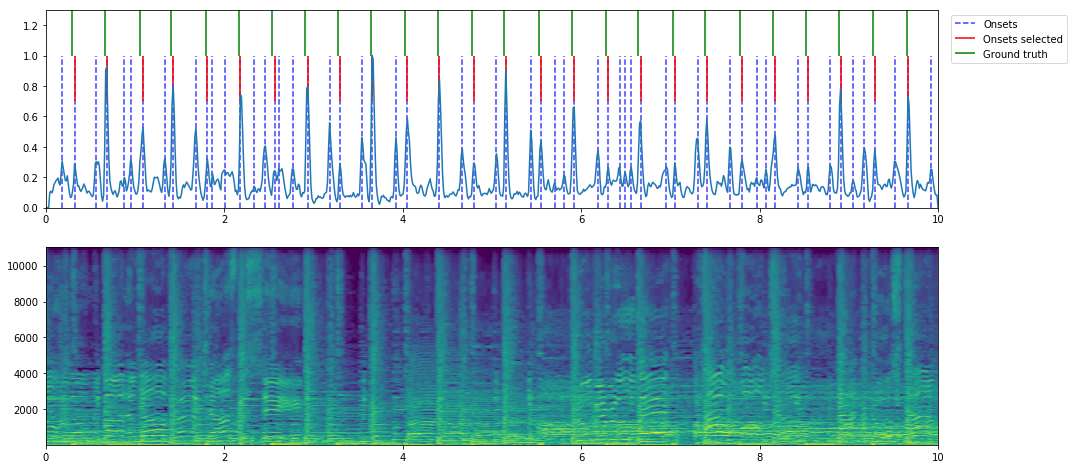

In [3]:
i = np.random.randint(len(trainset))
print(f'{i}/{len(trainset)}')
audiobeats = trainset[i]
print(f'Stretch: {audiobeats.stretch:.4f}')
print(f' Offset: {audiobeats.offset:.4f}')
beatfinder.display.showdata(audiobeats)

F measure: 1.00


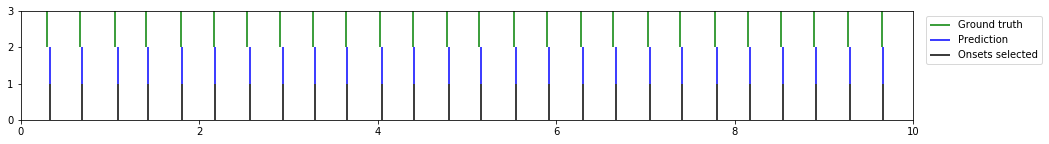

In [4]:
spec, onsets, isbeat, beats = audiobeats.get_data()
onsets_selected = beatfinder.utils.onsets_selected(onsets, isbeat)
pred_beats, bpm = beatfinder.utils.beat_track(onsets_selected)
beatfinder.display.showprediction(beats, pred_beats, onsets_selected)
print(f'F measure: {beatfinder.utils.F_measure(beats, pred_beats):.2f}')

# Setup datasets for pytorch

In [5]:
totensor = beatfinder.model.ToTensor(device)
trainset.transform = totensor
validset.transform = totensor

# Find learning rate

In [ ]:
model = beatfinder.model.BeatFinder()
model.to(device)

In [ ]:
dataloader = DataLoader(trainset, batch_size=4, shuffle=True)
n_mb = len(dataloader) # number of mini batches
print(f'{n_mb} mini batches')
lr = (10. ** -np.arange(0, 5, 5 / n_mb))[::-1]

In [ ]:
losses = np.zeros(n_mb)
for i, (specs, onsets, isbeat) in enumerate(dataloader):
    model.set_lr(lr[i])
    tn, fp, fn, tp, loss = model.learn(specs, onsets, isbeat)
    losses[i] = loss
    print(f'{i + 1}/{n_mb}')

In [ ]:
plt.figure(figsize=(7, 4))
plt.ylim(0.6, 0.8)
plt.semilogx(lr, losses);

# Train

In [8]:
model = beatfinder.model.BeatFinder()
model.to(device)
model.set_lr(0.0005)
print(model)
model.eval()
model.freeze()

BeatFinder(
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (hid_to_beat): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): NLLLoss()
)


In [9]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -------------------
| tp:   0 | fp:   0 |
| fn: 134 | tn: 210 |
 -------------------
 Accuracy: 0.6105
Precision: nan
   Recall: nan
F-measure: nan
     Loss: 0.6856


In [10]:
model.unfreeze()
model.train();

In [11]:
train_hist, valid_hist = model.fit(trainset, validset, batch_size=4, epochs=2)

| Epoch 1 | TL: 0.656 | VL: 0.776 | TF: 0.499 | VF: 0.567 | TA: 0.606 | VA: 0.494 | 6.25 s/b | 0:00:56 | ETA: 0:00:56 |
| Epoch 2 | TL: 0.498 | VL: 1.132 | TF: 0.749 | VF: 0.608 | TA: 0.773 | VA: 0.573 | 6.69 s/b | 0:01:00 | ETA: 0:00:00 |


In [ ]:
# torch.save(model.state_dict(), './data/model_09.pt')

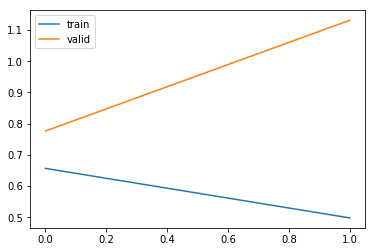

In [12]:
plt.plot(np.mean(train_hist[:, :, 4], axis=1), label='train')
plt.plot(valid_hist[:, 4], label='valid')
plt.legend();

In [13]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -------------------
| tp: 115 | fp: 127 |
| fn:  19 | tn:  83 |
 -------------------
 Accuracy: 0.5756
Precision: 0.4752
   Recall: 0.8582
F-measure: 0.6117
     Loss: 1.1298
